# Probabilities

In [1]:
from matplotlib import pyplot as plt
from fractions import Fraction
import poisson_approval as pa

## Random Factories

The package provides a large variety of random factories to generate **profiles**, **strategies** or **tau-vectors**. For example, define a random factory of tau-vectors:

In [2]:
rand_tau = pa.RandTauVectorUniform()

Then use this random factory to generate a tau-vector:

In [3]:
tau = rand_tau()
tau

<a: 0.12899531221204752, ab: 0.029093853592319863, ac: 0.1813635425327782, b: 0.12359657142207547, bc: 0.24777668308677925, c: 0.2891740371539997> ==> c

Most random factories of the package also have a "grid" counterpart where the coefficients are fractions of a given denominator. This is convenient to generate less "messy" examples:

In [4]:
rand_tau = pa.RandTauVectorGridUniform(denominator=100)
tau = rand_tau()
tau

<a: 17/100, ab: 13/50, ac: 3/50, b: 13/100, bc: 1/5, c: 9/50> ==> b

Also, most random factories have options that enable to finely tune the distribution:

In [5]:
rand_tau = pa.RandTauVectorUniform(
    ballots=['a', 'b'], 
    d_ballot_fixed_share={'c': 0.1}, 
    voting_rule=pa.PLURALITY
)
tau = rand_tau()
tau

<a: 0.018593636074880373, b: 0.8814063639251196, c: 0.1> ==> b (Plurality)

For more information, cf. the *Reference* section on random factories.

## Conditional Random Factory

*RandConditional* is a random factory implementing rejection sampling. It needs:

* Another random factory that is responsible for generating the objects,
* A test that the objects must meet,
* A maximum number of trials before renouncing (which can be *None* if you want to draw objects forever, until finding one that meets the test).

Here, we use a conditional random factory to generate an example of *TauVector* with a direct focus:

In [6]:
def test_direct_focus(tau):
    return tau.focus == pa.Focus.DIRECT

In [7]:
rand_tau = pa.RandConditional(
    factory=pa.RandTauVectorGridUniform(denominator=100),
    test=test_direct_focus,
    n_trials_max=None
)
tau = rand_tau()
tau

<a: 3/100, ab: 9/25, ac: 11/100, b: 27/100, bc: 7/50, c: 9/100> ==> b

Alternatively, *RandConditional* accepts a tuple of factories, and a test on the tuple of the results. Here is an example of a *ProfileNoisyDiscrete* and a *StrategyOrdinal*, such that the strategy is an equilibrium for the profile:

In [8]:
rand_profile = pa.RandProfileNoisyDiscreteGridUniform(
    denominator=100,
    types=[('abc', 0.4, 0.01),
           ('bac', 0.2, 0.01),
           ('cab', 0.7, 0.01)]
)
rand_strategy = pa.RandStrategyOrdinalUniform()
def test_is_equilibrium(profile, strategy):
    return profile.is_equilibrium(strategy) == pa.EquilibriumStatus.EQUILIBRIUM

In [9]:
rand_example = pa.RandConditional(
    factory=(rand_profile, rand_strategy),
    test=test_is_equilibrium,
    n_trials_max=None
)
profile, strategy = rand_example()
print(profile)
print(strategy)

<abc 0.4 ± 0.01: 71/100, bac 0.2 ± 0.01: 29/100> (Condorcet winner: a)
<abc: a, acb: a, bac: b, bca: bc, cab: ac, cba: bc>


## Probability Estimation

To compute a probability, use the function *probability*.

For example, estimate the probability that a *TauVector* drawn uniformly at random has a direct focus:

In [10]:
def test_direct_focus(tau):
    return tau.focus == pa.Focus.DIRECT

In [11]:
pa.probability(
    factory=pa.RandTauVectorUniform(),
    n_samples=100,
    test=test_direct_focus
)

0.54

To avoid the definition of an auxiliary function, you can use a *lambda*. For example:

In [12]:
pa.probability(
    factory=pa.RandTauVectorUniform(),
    n_samples=100,
    test=lambda tau: tau.focus == pa.Focus.DIRECT
)

0.47

You can also compute a conditional probability. For example, the probability that a *ProfileNoisyDiscrete* (generated by the random factory defined below) has an ordinal equilibrium, conditionally on having a strict Condorcet winner:

In [13]:
rand_profile = pa.RandProfileNoisyDiscreteUniform(
    types=[('abc', 0.4, 0.01),
           ('bac', 0.2, 0.01),
           ('cab', 0.7, 0.01)]
)
def test_exists_ordinal_equilibrium(profile):
    return len(profile.analyzed_strategies_ordinal.equilibria) > 0
def test_is_strictly_condorcet(profile):
    return profile.is_profile_condorcet == 1.0

In [14]:
pa.probability(
    factory=rand_profile,
    n_samples=100,
    test=test_exists_ordinal_equilibrium,
    conditional_on=test_is_strictly_condorcet
)

1.0

You can also use a tuple of random factories, and tests on the tuple of the results. For example, estimate the probability that a random *StrategyOrdinal* is an equilibrium for a random *ProfileNoisyDiscrete* (generated by the random factory defined below), conditionally on the fact that the profile has a strict Condorcet winner and that the initial strategy elects the Condorcet winner:

In [15]:
rand_profile = pa.RandProfileNoisyDiscreteUniform(
    types=[('abc', 0.4, 0.01),
           ('bac', 0.2, 0.01),
           ('cab', 0.7, 0.01)]
)
rand_strategy = pa.RandStrategyOrdinalUniform()
def test_is_equilibrium(profile, strategy):
    return profile.is_equilibrium(strategy) == pa.EquilibriumStatus.EQUILIBRIUM
def test_elect_condorcet_winner(profile, strategy):
    return (profile.is_profile_condorcet == 1. 
            and profile.tau(strategy).winners == profile.condorcet_winners)

In [16]:
pa.probability(
    factory=(rand_profile, rand_strategy),
    n_samples=100,
    test=test_is_equilibrium,
    conditional_on=test_elect_condorcet_winner
)

0.31

Finally, you can also use a tuple of tests in order to estimate several probabilities with the same sample. For example, estimate the probability that a *TauVector* drawn uniformly at random is direct, forward-focused, backward-focused, or unfocused:

In [17]:
pa.probability(
    factory=pa.RandTauVectorUniform(),
    n_samples=100,
    test=(lambda tau: tau.focus == pa.Focus.DIRECT, 
          lambda tau: tau.focus == pa.Focus.FORWARD_FOCUSED,
          lambda tau: tau.focus == pa.Focus.BACKWARD_FOCUSED,
          lambda tau: tau.focus == pa.Focus.UNFOCUSED)
)

(0.42, 0.58, 0.0, 0.0)

## Image Distribution Estimation

To compute an image distribution, use the function *image_distribution*.

For example, when drawing a *ProfileNoisyDiscrete* (with the random factory defined below) and an initial *StrategyOrdinal* at random, and when applying iterated voting, let us estimate the distribution of the length of the cycle to which it converges:

In [18]:
rand_profile = pa.RandProfileNoisyDiscreteUniform(
    types=[('abc', 0.4, 0.01),
           ('bca', 0.2, 0.01),
           ('cab', 0.7, 0.01)]
)
rand_strategy = pa.RandStrategyOrdinalUniform()

In [19]:
def len_cycle(profile, strategy_ini):
    cycle = profile.iterated_voting(init=strategy_ini, n_max_episodes=100)['cycle_taus_actual']
    return len(cycle)

In [20]:
d_len_occurrences = pa.image_distribution(
    factory=(rand_profile, rand_strategy),
    n_samples=100, f=len_cycle)
d_len_occurrences

{1: 0.18, 2: 0.02, 3: 0.8}

<BarContainer object of 3 artists>

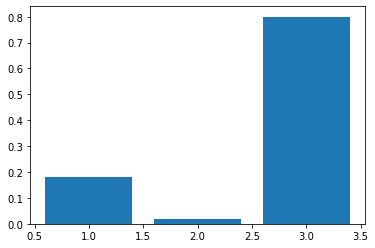

In [21]:
plt.bar(d_len_occurrences.keys(), d_len_occurrences.values())